In [43]:
# ==============================================================================
# CELL 1: SETUP, CONFIGURATION, AND DATA PREPROCESSING FOR DATASET C
# ==============================================================================

# 1. Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
np.random.seed(12345)


# 2. Define File Paths for Dataset C
train_file = '../Data/Input/pairC_train.csv'
test_features_file = '../Data/Input/pairC_test_features.csv'

# 3. Load the Training Data
train_df = pd.read_csv(train_file)

# 4. Separate Features (X) and Target (y)
features = [col for col in train_df.columns if col not in ['t', 'return']]
X_train_full = train_df[features].values
y_train_full = train_df['return'].values

# 5. Create an Internal Train-Validation Split
validation_split_ratio = 0.8
split_index = int(len(X_train_full) * validation_split_ratio)
X_train_internal_unscaled = X_train_full[:split_index]
X_validation_unscaled = X_train_full[split_index:]
y_train_internal = y_train_full[:split_index]
y_validation = y_train_full[split_index:]

# 6. Apply Feature Scaling
scaler = StandardScaler()
scaler.fit(X_train_internal_unscaled)
X_train_internal = scaler.transform(X_train_internal_unscaled)
X_validation = scaler.transform(X_validation_unscaled)

# 7. Print a summary to verify
print("--- Task 3 Setup for Dataset C (with Scaling) ---")
print(f"Total training samples loaded: {len(train_df)}")
print(f"Number of features: {X_train_full.shape[1]}")
print(f"Internal training set size: {len(X_train_internal)}")
print(f"Internal validation set size: {len(X_validation)}")
print("-------------------------------------------------")

--- Task 3 Setup for Dataset C (with Scaling) ---
Total training samples loaded: 360
Number of features: 1800
Internal training set size: 288
Internal validation set size: 72
-------------------------------------------------


--- Exploratory Data Analysis for ../Data/Input/pairC_train.csv ---

[1] Basic DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Columns: 1802 entries, t to return
dtypes: float64(1801), int64(1)
memory usage: 4.9 MB

[2] Descriptive Statistics for all columns:


,count,mean,std,min,25%,50%,75%,max
t,360.0,180.500000,104.067286,1.000000,90.750000,180.500000,270.250000,360.000000
feature1,360.0,-0.023337,0.991793,-2.403978,-0.650965,0.063052,0.584030,3.267500
feature2,360.0,-0.030441,0.996069,-2.829543,-0.687776,-0.100812,0.578541,2.774262
feature3,360.0,0.000053,0.935195,-2.601895,-0.583646,0.017169,0.563756,2.518521
feature4,360.0,0.041552,0.976943,-2.400789,-0.598351,0.070569,0.678418,2.634248
...,...,...,...,...,...,...,...,...
feature1797,360.0,0.028528,1.005218,-2.513897,-0.699932,-0.008222,0.745165,2.944576
feature1798,360.0,-0.028425,1.001474,-2.717486,-0.719307,-0.007507,0.652244,2.847526
feature1799,360.0,-0.041520,1.007067,-2.842334,-0.684759,-0.045174,0.647583,2.625140
feature1800,360.0,0.086071,1.072135,-2.772767,-0.639493,0.061772,0.742095,3.601786



[3] Analysis of the Target Variable ('return'):


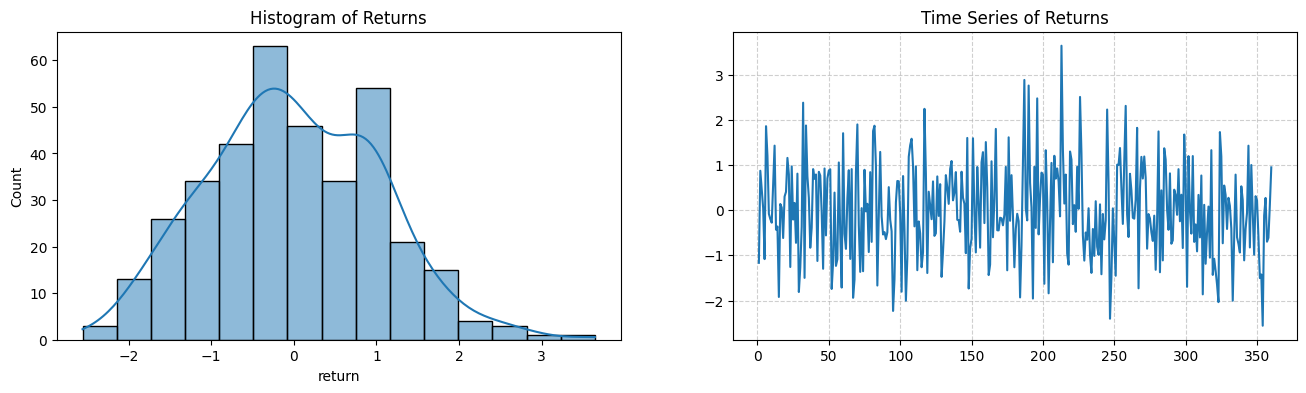


[4] Feature Correlation Heatmap:


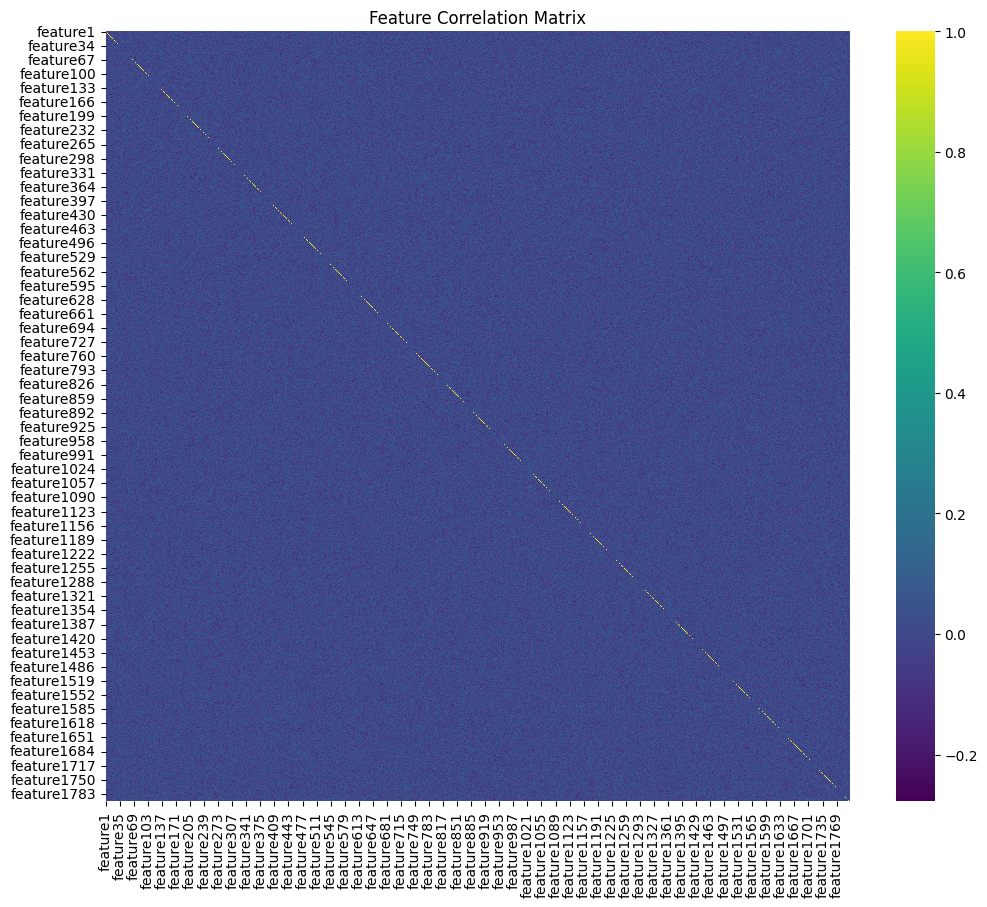

In [44]:
# ==============================================================================
# CELL 2: EXPLORATORY DATA ANALYSIS (EDA) FOR DATASET C
# ==============================================================================

# --- 1. Load Data for Exploration ---
df_eda = pd.read_csv(train_file)
features_eda = [col for col in df_eda.columns if col not in ['t', 'return']]
print(f"--- Exploratory Data Analysis for {train_file} ---")

# --- 2. Basic Information ---
print("\n[1] Basic DataFrame Info:")
df_eda.info()

# --- 3. Descriptive Statistics ---
print("\n[2] Descriptive Statistics for all columns:")
display(df_eda.describe().T)

# --- 4. Target Variable ('return') Analysis ---
print("\n[3] Analysis of the Target Variable ('return'):")
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(df_eda['return'], kde=True, ax=axes[0])
axes[0].set_title('Histogram of Returns')
axes[1].plot(df_eda['t'], df_eda['return'], label='Return')
axes[1].set_title('Time Series of Returns')
axes[1].grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 5. Feature Correlation Analysis ---
print("\n[4] Feature Correlation Heatmap:")
corr_matrix = df_eda[features_eda].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='viridis', annot=False)
plt.title('Feature Correlation Matrix')
plt.show()

In [45]:
# ==============================================================================
# CELL 3: MODEL EVALUATION ENGINE
# ==============================================================================

def evaluate_model(model_instance, P1, X_train, y_train, X_val, y_val):
    """
    Trains a model with P1 features and evaluates its performance on the validation set,
    returning a dictionary of key metrics.
    """
    if P1 == 0:
        return {'sharpe_ratio': np.nan, 'expected_timing_return': np.nan, 'r_squared': np.nan}

    X_train_p1 = X_train[:, :P1]
    X_val_p1 = X_val[:, :P1]

    try:
        model_instance.fit(X_train_p1, y_train)
    except Exception:
        return {'sharpe_ratio': np.nan, 'expected_timing_return': np.nan, 'r_squared': np.nan}

    y_pred_val = model_instance.predict(X_val_p1)

    timing_return_series = y_pred_val * y_val
    expected_timing_return = np.mean(timing_return_series)
    
    denominator_sr = np.sqrt(np.mean(timing_return_series**2))
    sharpe_ratio = expected_timing_return / denominator_sr if denominator_sr != 0 else 0
    
    e_r_pred_sq = np.mean(y_pred_val**2)
    e_r_test_sq = np.mean(y_val**2)
    r_squared = (2 * expected_timing_return - e_r_pred_sq) / e_r_test_sq if e_r_test_sq != 0 else -999

    return {
        'sharpe_ratio': sharpe_ratio,
        'expected_timing_return': expected_timing_return,
        'r_squared': r_squared
    }

In [46]:
# ==============================================================================
# CELL 4: COARSE HYPERPARAMETER SEARCH
# ==============================================================================

z_grid_coarse = [0, 0.01, 0.1, 0.5, 1, 5, 10, 25, 50, 100, 200]
cq_grid_coarse = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 7.0, 10.0]

P_full = X_train_full.shape[1]
T_tr_internal = len(X_train_internal)

validation_results = []
print("--- Starting Coarse Hyperparameter Search for Dataset C ---")

for model_name in ['Ridge', 'Lasso']:
    for cq in cq_grid_coarse:
        P1 = int(cq * T_tr_internal)
        if P1 <= 0 or P1 > P_full: continue
            
        for z in z_grid_coarse:
            if model_name == 'Ridge':
                alpha = z * T_tr_internal if z > 0 else 1e-8
                model_instance = Ridge(alpha=alpha, fit_intercept=False)
            elif model_name == 'Lasso':
                alpha = z / (2 * T_tr_internal) if z > 0 else 1e-8
                model_instance = Lasso(alpha=alpha, fit_intercept=False, max_iter=2000, tol=1e-3, selection='random')

            metrics = evaluate_model(model_instance, P1, X_train_internal, y_train_internal, X_validation, y_validation)
            
            validation_results.append({'model': model_name, 'cq': cq, 'z': z, 'P1': P1, 'validation_sharpe': metrics['sharpe_ratio']})

validation_results_df = pd.DataFrame(validation_results)
best_params_coarse = validation_results_df.loc[validation_results_df['validation_sharpe'].idxmax()]

print("\n--- Coarse Search Finished ---")
print("Best parameters found from coarse scan:")
print(best_params_coarse)

--- Starting Coarse Hyperparameter Search for Dataset C ---


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.140e-01, tolerance: 3.205e-01
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.756e-01, tolerance: 3.205e-01
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter


--- Coarse Search Finished ---
Best parameters found from coarse scan:
model                   Ridge
cq                        5.0
z                         0.0
P1                       1440
validation_sharpe    0.094502
Name: 99, dtype: object


In [47]:
# ==============================================================================
# CELL 5: FINE-TUNED HYPERPARAMETER SEARCH
# ==============================================================================

# Automatically define finer grids around the best parameters from the coarse scan
z_center = best_params_coarse['z']
cq_center = best_params_coarse['cq']
z_grid_finetune = np.linspace(max(0, z_center - 10), z_center + 10, 5)
cq_grid_finetune = np.round(np.linspace(max(0.1, cq_center - 0.5), cq_center + 0.5, 5), 3)

best_model_name = best_params_coarse['model']
finetune_results = []
print(f"\n--- Starting Fine-Tuned Search for {best_model_name} model (Dataset C) ---")
print(f"New Z grid: {z_grid_finetune}")
print(f"New CQ grid: {cq_grid_finetune}")

for cq in cq_grid_finetune:
    P1 = int(cq * T_tr_internal)
    if P1 <= 0 or P1 > P_full: continue
    for z in z_grid_finetune:
        if best_model_name == 'Ridge':
            alpha = z * T_tr_internal if z > 0 else 1e-8
            model_instance = Ridge(alpha=alpha, fit_intercept=False)
        elif best_model_name == 'Lasso':
            alpha = z / (2 * T_tr_internal) if z > 0 else 1e-8
            model_instance = Lasso(alpha=alpha, fit_intercept=False, max_iter=2000, tol=1e-3, selection='random')

        metrics = evaluate_model(model_instance, P1, X_train_internal, y_train_internal, X_validation, y_validation)
        finetune_results.append({'model': best_model_name, 'cq': cq, 'z': z, 'P1': P1, 'validation_sharpe': metrics['sharpe_ratio']})

finetune_results_df = pd.DataFrame(finetune_results)
best_params_finetuned = finetune_results_df.loc[finetune_results_df['validation_sharpe'].idxmax()]

print("\n--- Fine-Tuned Search Finished ---")
print("Best parameters after fine-tuning are:")
print(best_params_finetuned)


--- Starting Fine-Tuned Search for Ridge model (Dataset C) ---
New Z grid: [ 0.   2.5  5.   7.5 10. ]
New CQ grid: [4.5  4.75 5.   5.25 5.5 ]

--- Fine-Tuned Search Finished ---
Best parameters after fine-tuning are:
model                   Ridge
cq                        5.5
z                         0.0
P1                       1584
validation_sharpe    0.099686
Name: 20, dtype: object


In [48]:
# ==============================================================================
# CELL 6: TRAIN FINAL MODEL AND GENERATE SUBMISSION FOR DATASET C
# ==============================================================================

print("\n--- Generating Final Submission File for Dataset C ---")

# Use the best parameters from the fine-tuned search
final_best_params = best_params_finetuned 
print("Using final best parameters:")
print(final_best_params)

best_model_name = final_best_params['model']
best_z = final_best_params['z']
P1_best = int(final_best_params['P1'])

# Re-fit the scaler on the FULL training data
final_scaler = StandardScaler()
final_scaler.fit(X_train_full)
X_train_full_scaled = final_scaler.transform(X_train_full)

# Configure and train the final model on the FULL scaled training data
T_tr_full = len(X_train_full) 
if best_model_name == 'Lasso':
    alpha_best = best_z / (2 * T_tr_full) if best_z > 0 else 1e-8
    final_model = Lasso(alpha=alpha_best, fit_intercept=False, max_iter=2000, tol=1e-3, selection='random')
elif best_model_name == 'Ridge':
     alpha_best = best_z * T_tr_full if best_z > 0 else 1e-8
     final_model = Ridge(alpha=alpha_best, fit_intercept=False)

final_model.fit(X_train_full_scaled[:, :P1_best], y_train_full)
print("\nFinal model trained successfully on full dataset.")

# Load, scale test features, and generate predictions
test_features_df = pd.read_csv(test_features_file)
X_test_unscaled = test_features_df[features].values
X_test_scaled = final_scaler.transform(X_test_unscaled)
y_predictions = final_model.predict(X_test_scaled[:, :P1_best])

# Create and save the submission file
submission_df = pd.DataFrame({'t': test_features_df['t'], 'yhat': y_predictions})
student_id = 'A0330643M'

# Ensure the output folder exists
import os
os.makedirs('Data/Output', exist_ok=True)

# Save to the correct folder
submission_filename = f'Data/Output/{student_id}_predictions_C.csv'  # <-- Added folder path
submission_df.to_csv(submission_filename, index=False, encoding='utf-8')

print(f"\nSubmission file '{submission_filename}' created successfully.")
display(submission_df.head())



--- Generating Final Submission File for Dataset C ---
Using final best parameters:
model                   Ridge
cq                        5.5
z                         0.0
P1                       1584
validation_sharpe    0.099686
Name: 20, dtype: object

Final model trained successfully on full dataset.

Submission file 'Data/Output/A0330643M_predictions_C.csv' created successfully.


,t,yhat
0,361,-0.253879
1,362,0.407785
2,363,0.164098
3,364,0.265651
4,365,0.135679
